In [92]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
test_pred = pd.read_hdf('../../_data/avg1-20170716-201659-test.h5')
test_pred[:3]

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
b'image_name',,,,,,,,,,,,,,,,,
test_0,0.001236,0.000014,0.000163,0.007768,0.000138,0.998413,0.000022,0.000012,0.000769,0.000192,0.001861,0.000228,0.999939,0.000317,0.000549,0.000054,0.000667
test_1,0.004746,0.000037,0.000289,0.005246,0.013420,0.999626,0.000043,0.000022,0.003971,0.000337,0.000085,0.000277,0.999886,0.000600,0.002667,0.000121,0.000971
test_2,0.003577,0.000019,0.000147,0.000070,0.000175,0.000041,0.000059,0.000030,0.001251,0.000119,0.000025,0.999927,0.999942,0.001184,0.000102,0.000120,0.005213


In [3]:
val_pred = pd.read_hdf('../../_data/avg1-20170716-201659-eval.h5')
val_pred[:3]

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
b'image_name',,,,,,,,,,,,,,,,,
train_0,0.001079,0.000014,0.000114,0.000228,0.000042,0.847091,0.000073,0.000027,0.000667,0.000153,0.903934,0.000762,0.999896,0.000372,0.000051,0.000038,0.001629
train_1,0.931325,0.001228,0.004702,0.000203,0.000226,0.999513,0.000013,0.000168,0.775591,0.013098,0.000114,0.000483,0.999935,0.800270,0.001093,0.005248,0.931579
train_2,0.000336,0.000002,0.000014,0.000074,0.000021,0.999868,0.000006,0.000002,0.000167,0.000028,0.000026,0.000064,0.999983,0.000095,0.000013,0.000004,0.000267


In [4]:
mosaic = pd.read_csv('../../_data/image_mosaic.csv', index_col=0)
mosaic = mosaic.set_index('image_name')
mosaic[:3]

,region,neigh_right,neigh_top_left,neigh_left,neigh_bottom_right,neigh_top,neigh_bottom,neigh_bottom_left,neigh_top_right
image_name,,,,,,,,,
train_0,30259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
train_1,147,NaN,NaN,NaN,train_23013,test_103,test_28280,NaN,NaN
train_2,8956,NaN,NaN,NaN,NaN,NaN,train_1448,NaN,NaN


In [122]:
mosaic = mosaic[['neigh_right', 'neigh_left', 'neigh_top', 'neigh_bottom']]
mosaic[:3]

,neigh_right,neigh_left,neigh_top,neigh_bottom
image_name,,,,
train_0,NaN,NaN,NaN,NaN
train_1,NaN,NaN,test_103,test_28280
train_2,NaN,NaN,NaN,train_1448


In [5]:
train_flat = pd.read_csv('../../_data/train_flat.csv', index_col=0)
train_flat[:3]

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
image_name,,,,,,,,,,,,,,,,,
train_0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
train_1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
train_2,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


In [6]:
def f2_score(y_true: np.ndarray, y_pred: np.ndarray, eps=1e-7) -> float:
    # same as fbeta_score(y_true, y_pred, beta=2, average='samples')
    # but faster
    tp = (y_true * y_pred).sum(axis=1)
    r = tp / y_true.sum(axis=1)
    p = tp / (y_pred.sum(axis=1) + eps)
    beta2 = 4
    f2 = (1 + beta2) * p * r / (beta2 * p + r + eps)
    return f2.mean()

In [66]:
threshold = 0.3132
original_score = f2_score(train_flat.as_matrix(), (val_pred > threshold).as_matrix())
original_score

0.93322134950985058

In [68]:
for th in np.linspace(0.25, 0.35, 100):
    score = f2_score(train_flat.as_matrix(), (val_pred > th).as_matrix())
    if score > original_score:
        print('{:.4f} {:.7f}'.format(th, score - original_score))

In [37]:
alpha = 0.05
cpred = val_pred.copy()
for cid in tqdm.tqdm_notebook(val_pred.index):
    try:
        values = mosaic.loc[cid].values
    except KeyError:
        pass
    else:
        for nb in values:
            if isinstance(nb, str) and nb.startswith('train'):
                cpred.loc[cid] = (1 - alpha) * cpred.loc[cid] + alpha * val_pred.loc[nb]
new_score = f2_score(train_flat.as_matrix(), (cpred > threshold).as_matrix())
print('{:.7f}, {:.7f}'.format(new_score, new_score - original_score))


0.9331596, -0.0000012


In [24]:
alpha = 0.05
for cls in val_pred.columns:
    cpred = val_pred.copy()
    for cid in val_pred.index:
        try:
            values = mosaic.loc[cid].values
        except KeyError:
            pass
        else:
            for nb in values:
                if isinstance(nb, str) and nb.startswith('train'):
                    cpred.loc[cid][cls] = (1 - alpha) * cpred.loc[cid][cls] + alpha * val_pred.loc[nb][cls]
    new_score = f2_score(train_flat.as_matrix(), (cpred > threshold).as_matrix())
    print('{:<25} {:.6f}, {:+.6f}'.format(cls, new_score, new_score - original_score))

agriculture               0.932879, -0.000282
artisinal_mine            0.932884, -0.000276
bare_ground               0.932902, -0.000259
blooming                  0.932905, -0.000256
blow_down                 0.932892, -0.000269
clear                     0.932871, -0.000289
cloudy                    0.932930, -0.000231
conventional_mine         0.932888, -0.000273
cultivation               0.932863, -0.000298
habitation                0.932865, -0.000296
haze                      0.932908, -0.000253
partly_cloudy             0.932848, -0.000312
primary                   0.932942, -0.000219
road                      0.932911, -0.000250
selective_logging         0.932886, -0.000274
slash_burn                0.932890, -0.000271
water                     0.932904, -0.000257


In [123]:
val_neigh_probs = pd.DataFrame(0, index=val_pred.index, columns=val_pred.columns)
for cid in tqdm.tqdm_notebook(val_pred.index):
    try:
        values = mosaic.loc[cid].values
    except KeyError:
        pass
    else:
        for nb in values:
            if isinstance(nb, str) and nb.startswith('train'):
                val_neigh_probs.loc[cid] += val_pred.loc[nb]

In [28]:
val_neigh_probs[:3]

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
b'image_name',,,,,,,,,,,,,,,,,
train_0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
train_1,0.980857,0.003297,0.006918,0.000105,0.000285,0.999417,0.000013,0.000241,0.063189,0.014725,0.000161,0.000453,0.999698,0.968939,0.000972,0.001095,0.925468
train_2,0.000325,0.000001,0.000010,0.000066,0.000015,0.999884,0.000005,0.000001,0.000148,0.000016,0.000022,0.000071,0.999988,0.000083,0.000011,0.000004,0.000349


In [125]:
val_neigh_counts = pd.DataFrame(0, index=val_pred.index, columns=val_pred.columns)
for cid in tqdm.tqdm_notebook(val_pred.index):
    try:
        values = mosaic.loc[cid].values
    except KeyError:
        pass
    else:
        for nb in values:
            if isinstance(nb, str) and nb.startswith('train'):
                val_neigh_counts.loc[cid] += train_flat.loc[nb]

In [27]:
val_neigh_counts[:3]

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
b'image_name',,,,,,,,,,,,,,,,,
train_0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
train_1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1
train_2,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


In [75]:
original_score = f2_score(train_flat.as_matrix(), (val_pred > threshold).as_matrix())
for alpha in [0.0005, 0.01, 0.03, 0.04, 0.045, 0.05, 0.055, 0.06, 0.07, 0.1]:
    cpred = (1 - alpha) * val_pred + alpha * val_neigh_probs
    new_score = f2_score(train_flat.as_matrix(), (cpred > threshold).as_matrix())
    print('alpha={:.2f}: {:.7f}, {:+.7f}'.format(alpha, new_score, new_score - original_score))

alpha=0.00: 0.9332026, -0.0000187
alpha=0.01: 0.9331651, -0.0000563
alpha=0.03: 0.9331642, -0.0000572
alpha=0.04: 0.9331625, -0.0000589
alpha=0.04: 0.9331808, -0.0000405
alpha=0.05: 0.9332447, +0.0000233
alpha=0.06: 0.9332182, -0.0000032
alpha=0.06: 0.9331998, -0.0000215
alpha=0.07: 0.9331211, -0.0001003
alpha=0.10: 0.9328927, -0.0003287


In [74]:
original_score = f2_score(train_flat.as_matrix(), (val_pred > threshold).as_matrix())
for alpha in [0.0005, 0.01, 0.03, 0.04, 0.045, 0.05, 0.055, 0.06, 0.07, 0.1]:
    cpred = (1 - alpha) * val_pred + alpha * val_neigh_counts
    new_score = f2_score(train_flat.as_matrix(), (cpred > threshold).as_matrix())
    print('alpha={:.2f}: {:.7f}, {:+.7f}'.format(alpha, new_score, new_score - original_score))

alpha=0.00: 0.9331996, -0.0000218
alpha=0.01: 0.9331845, -0.0000368
alpha=0.03: 0.9331307, -0.0000906
alpha=0.04: 0.9331464, -0.0000749
alpha=0.04: 0.9331916, -0.0000297
alpha=0.05: 0.9332088, -0.0000126
alpha=0.06: 0.9331642, -0.0000571
alpha=0.06: 0.9331404, -0.0000810
alpha=0.07: 0.9331235, -0.0000979
alpha=0.10: 0.9328104, -0.0004109


In [99]:
original_score = f2_score(train_flat.as_matrix(), (val_pred > threshold).as_matrix())
xs = np.linspace(-0.3, 0.3, 100)
scores_df = pd.DataFrame(index=xs)
for cls in val_pred.columns:
    print('{}'.format(cls))
    scores = []
    for alpha in xs:
        cpred = val_pred.copy()
        cpred[cls] = (1 - alpha) * val_pred[cls] + alpha * val_neigh_probs[cls]
        new_score = f2_score(train_flat.as_matrix(), (cpred > threshold).as_matrix())
        #print('alpha={:.3f}: {:.7f}, {:+.7f}'.format(alpha, new_score, new_score - original_score))
        scores.append(new_score - original_score)
    scores_df[cls] = scores

agriculture
artisinal_mine
bare_ground
blooming
blow_down
clear
cloudy
conventional_mine
cultivation
habitation
haze
partly_cloudy
primary
road
selective_logging
slash_burn
water


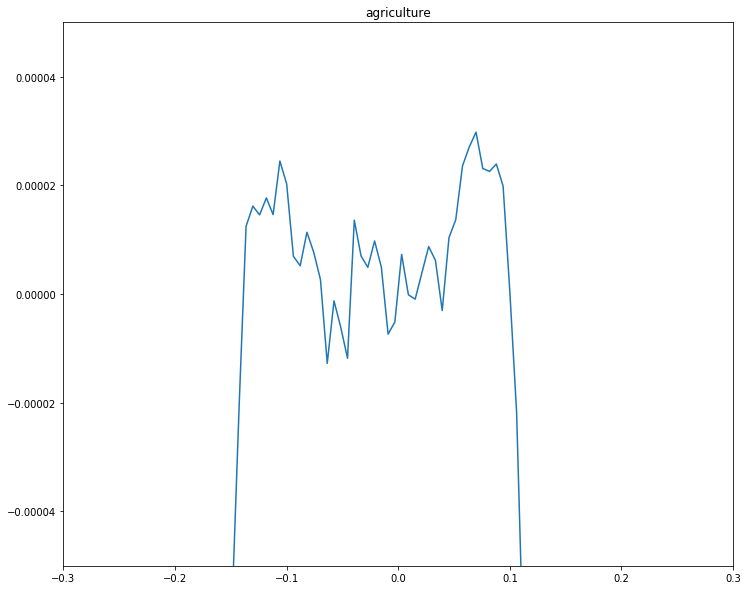

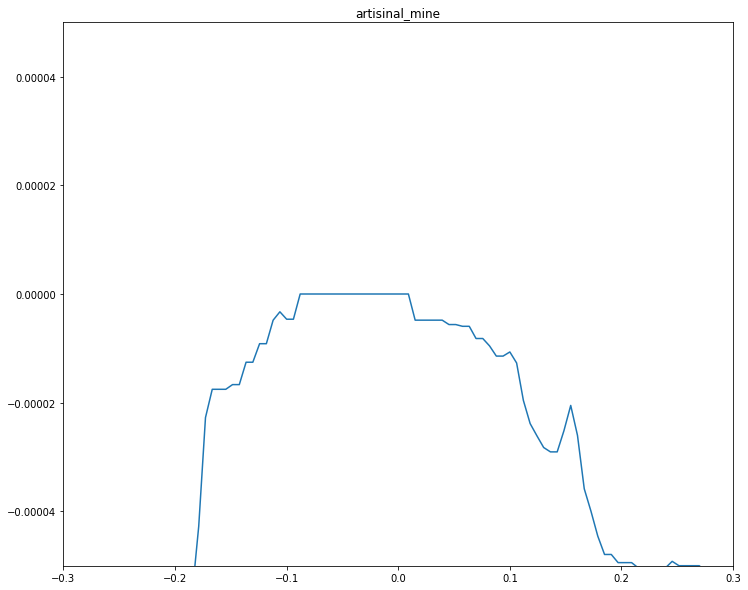

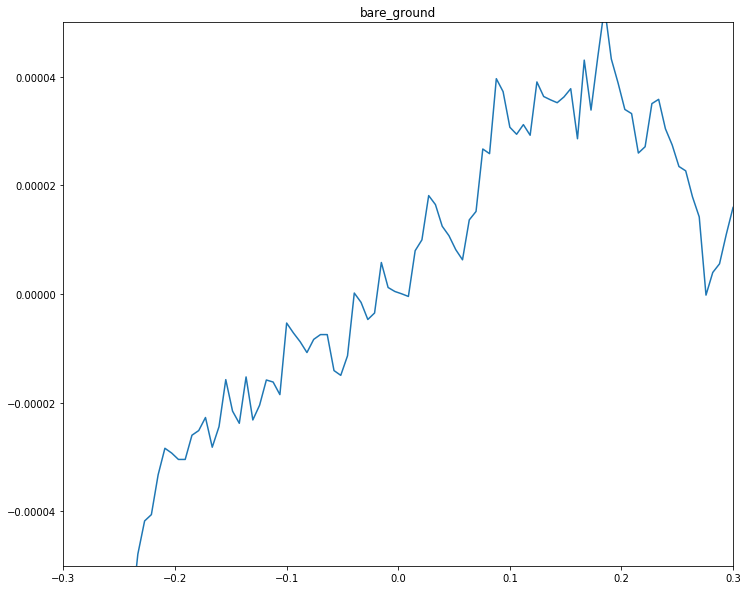

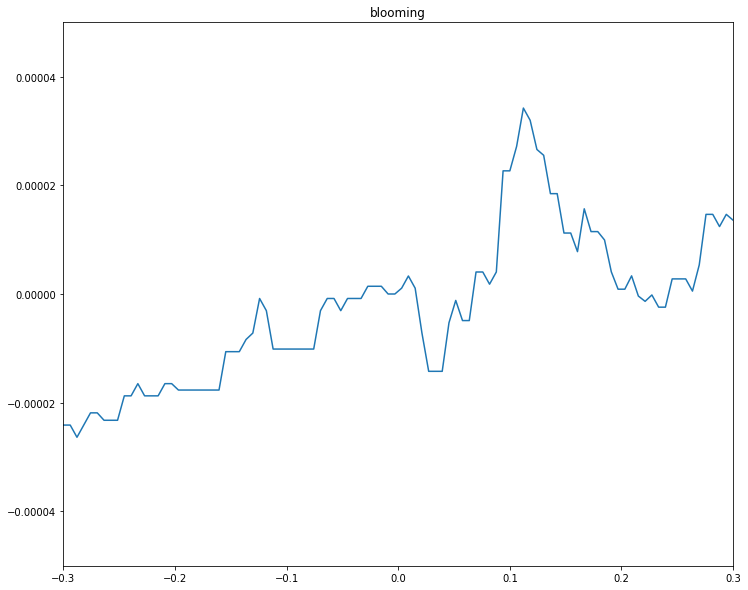

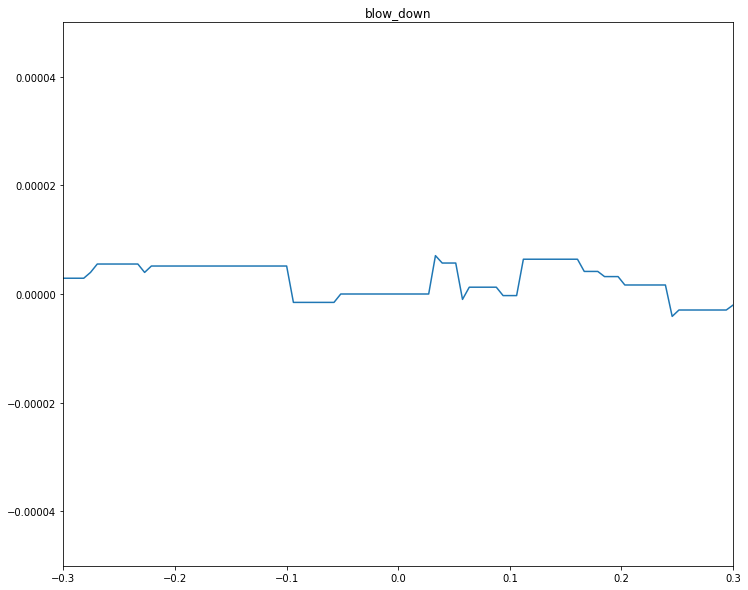

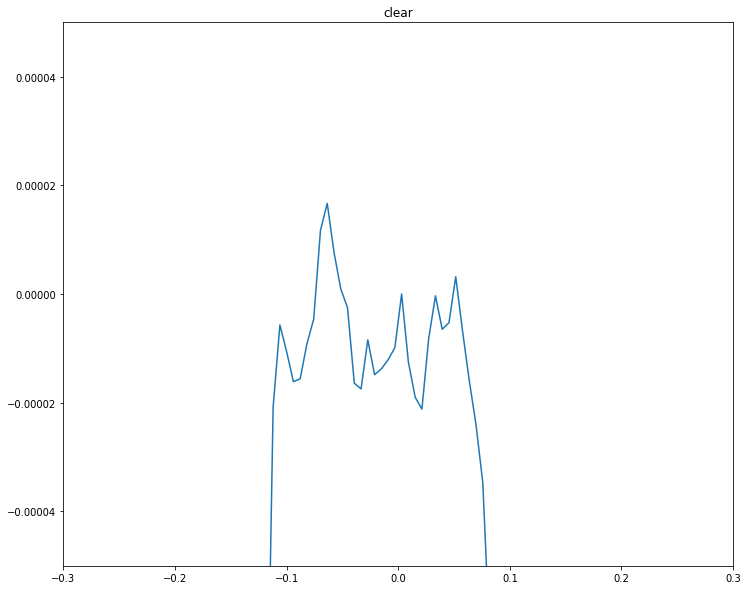

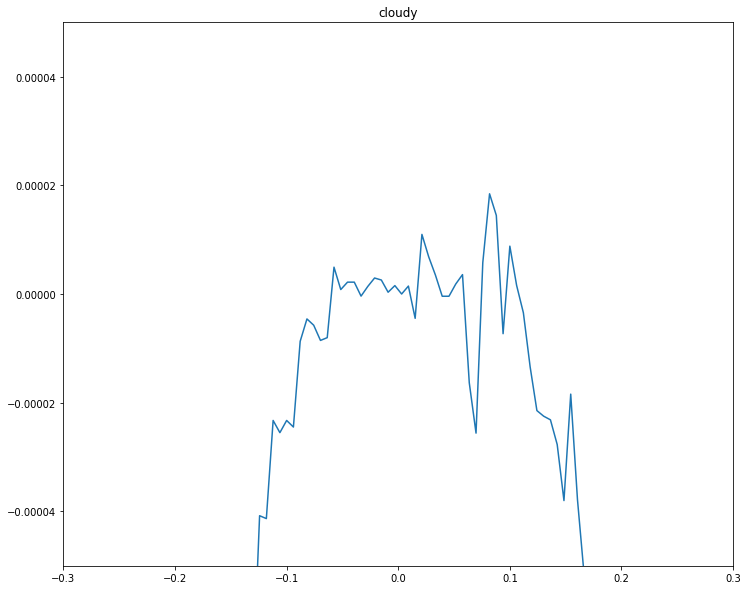

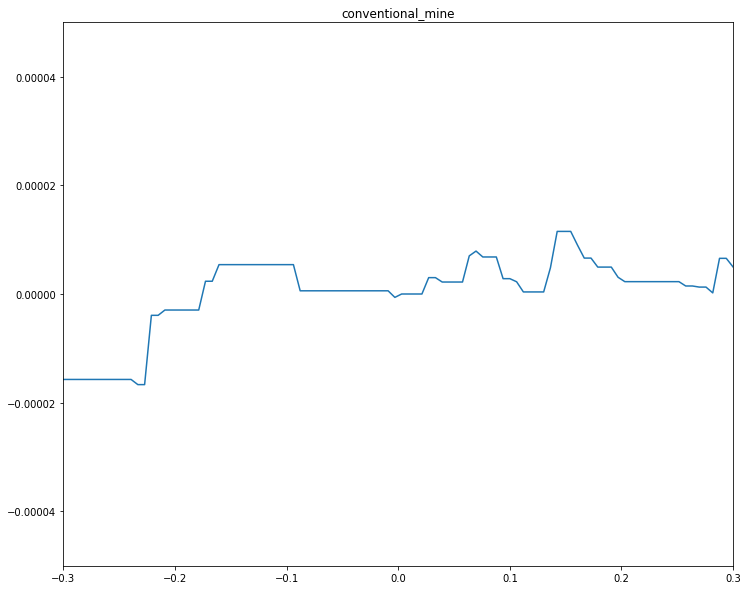

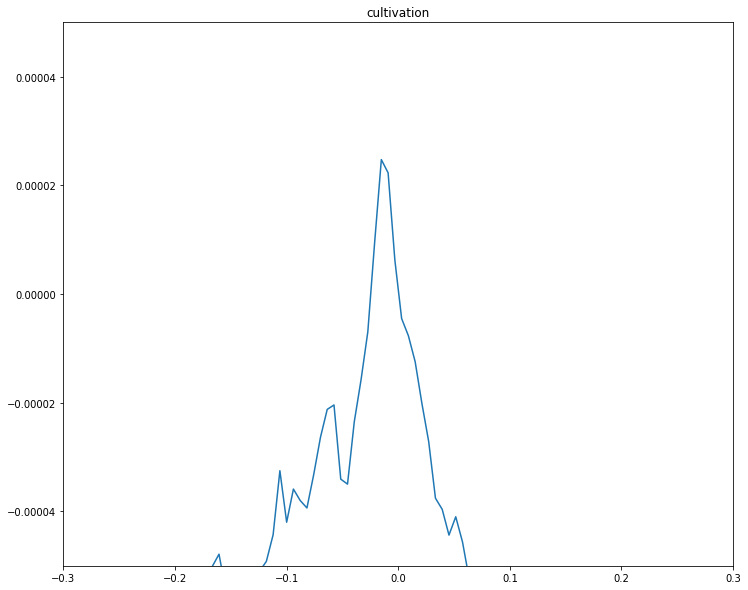

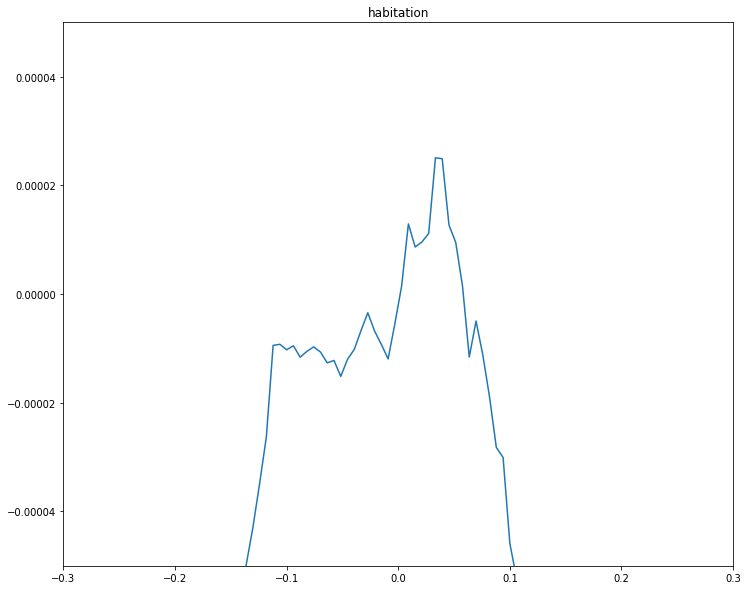

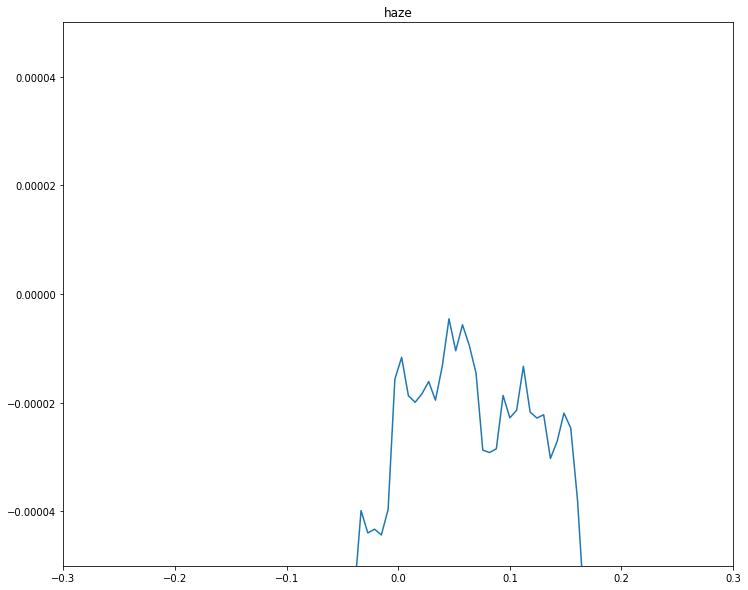

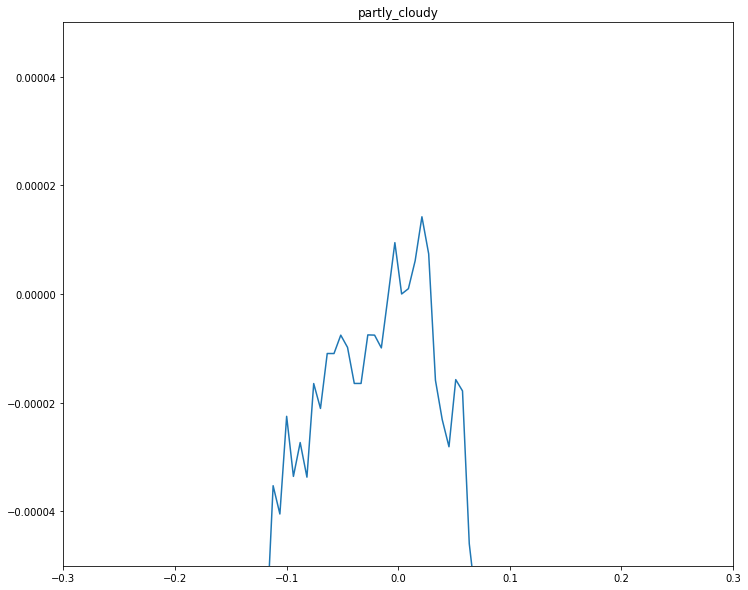

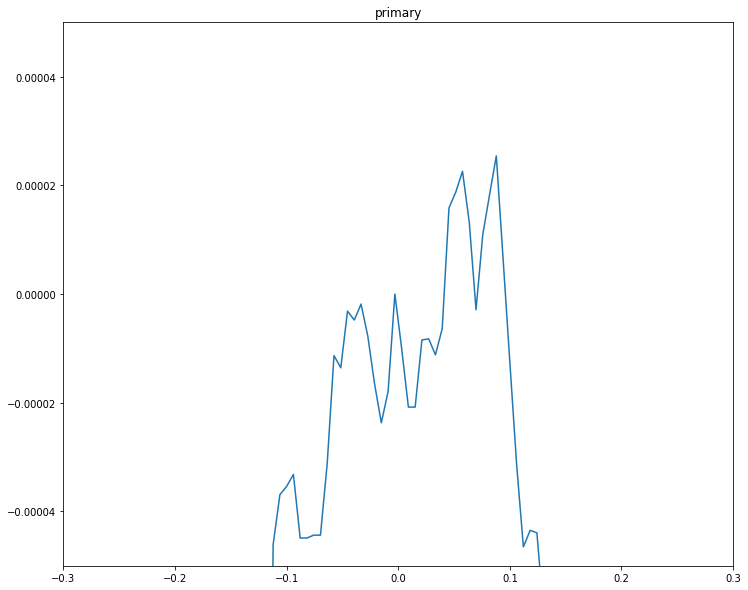

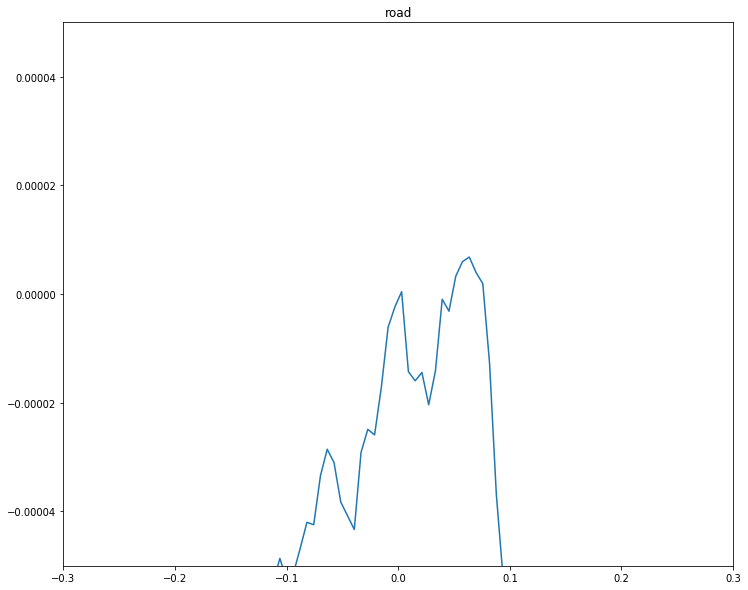

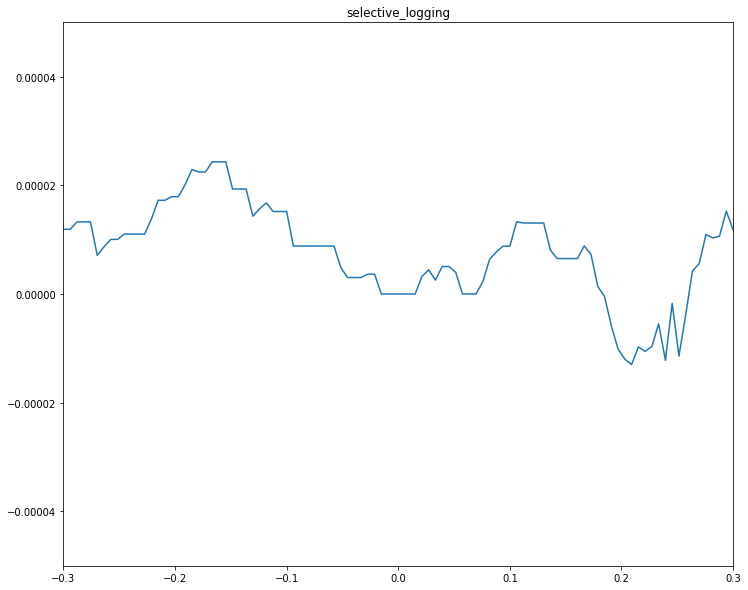

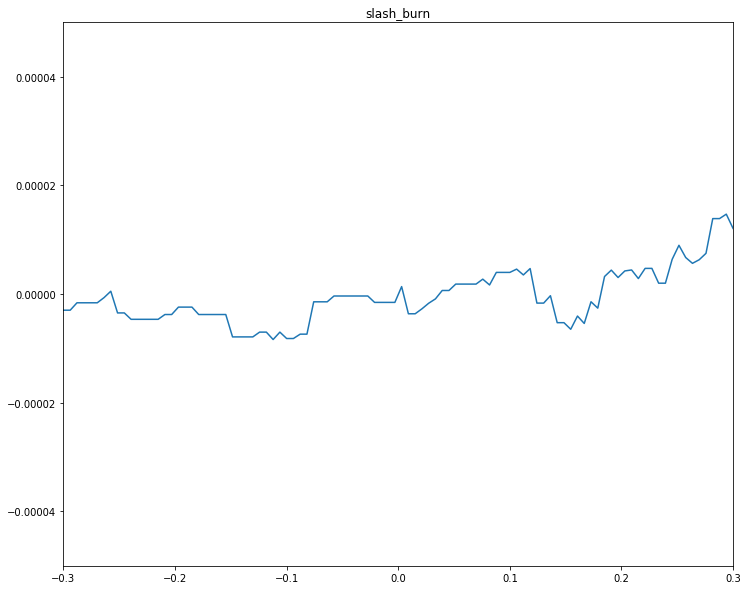

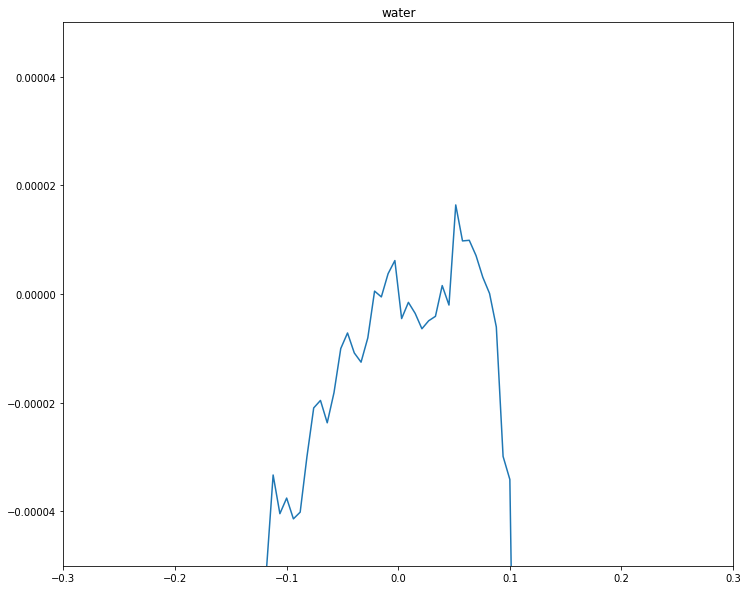

In [100]:
for cls in val_pred.columns:
    plt.figure()
    plt.title(cls)
    scores_df[cls].plot(figsize=(12, 10), ylim=(-0.00005, 0.00005));

In [101]:
original_score = f2_score(train_flat.as_matrix(), (val_pred > threshold).as_matrix())
xs = np.linspace(-0.3, 0.3, 100)
scores_count_df = pd.DataFrame(index=xs)
for cls in val_pred.columns:
    print('{}'.format(cls))
    scores = []
    for alpha in xs:
        cpred = val_pred.copy()
        cpred[cls] = (1 - alpha) * val_pred[cls] + alpha * val_neigh_counts[cls]
        new_score = f2_score(train_flat.as_matrix(), (cpred > threshold).as_matrix())
        #print('alpha={:.3f}: {:.7f}, {:+.7f}'.format(alpha, new_score, new_score - original_score))
        scores.append(new_score - original_score)
    scores_count_df[cls] = scores

agriculture
artisinal_mine
bare_ground
blooming
blow_down
clear
cloudy
conventional_mine
cultivation
habitation
haze
partly_cloudy
primary
road
selective_logging
slash_burn
water


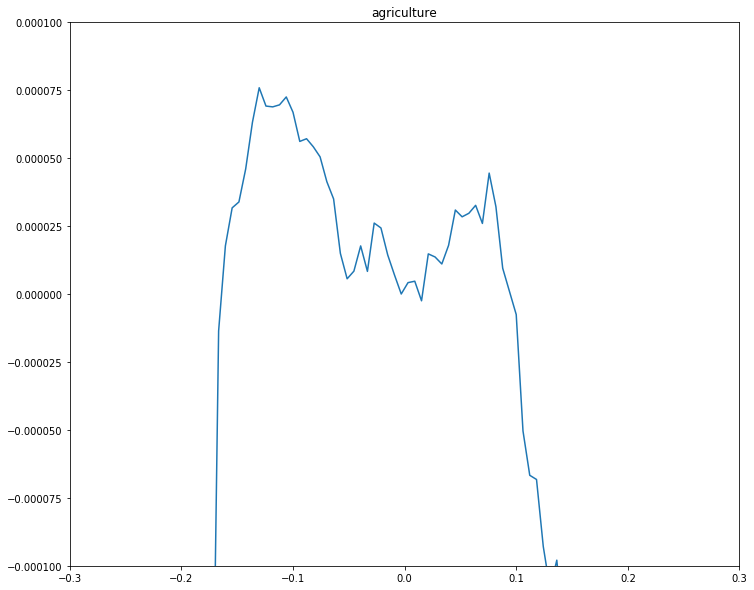

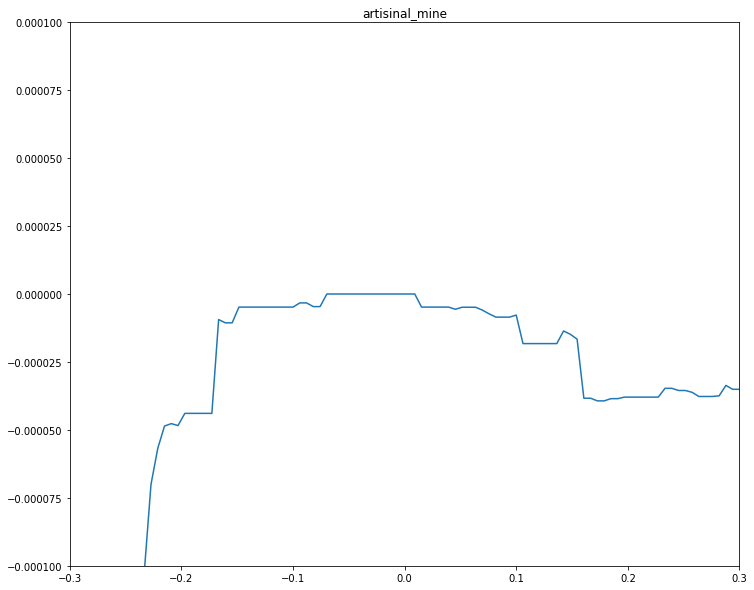

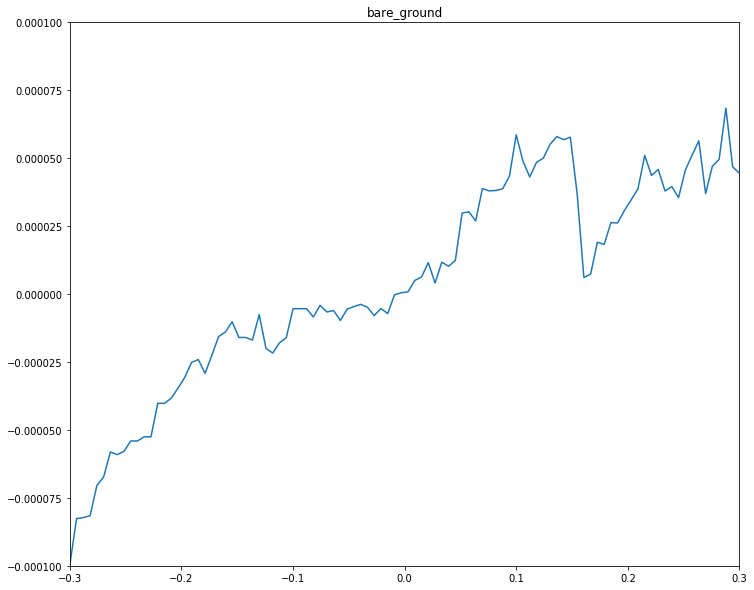

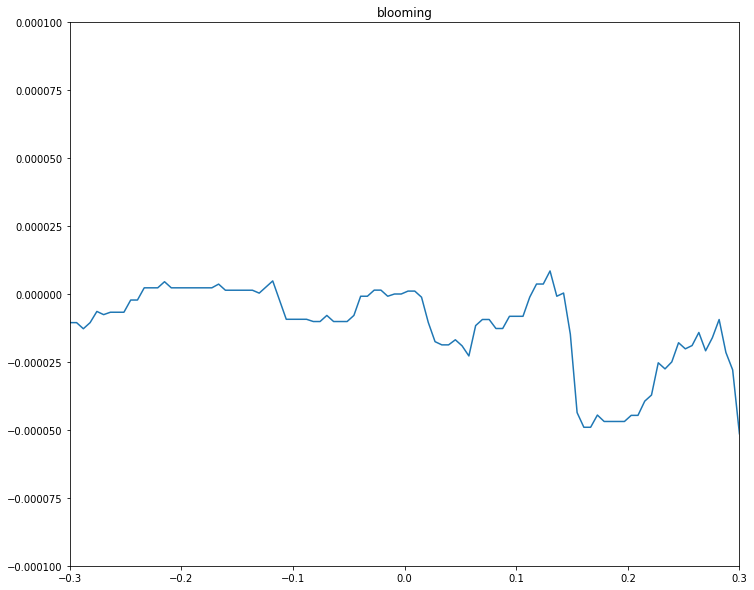

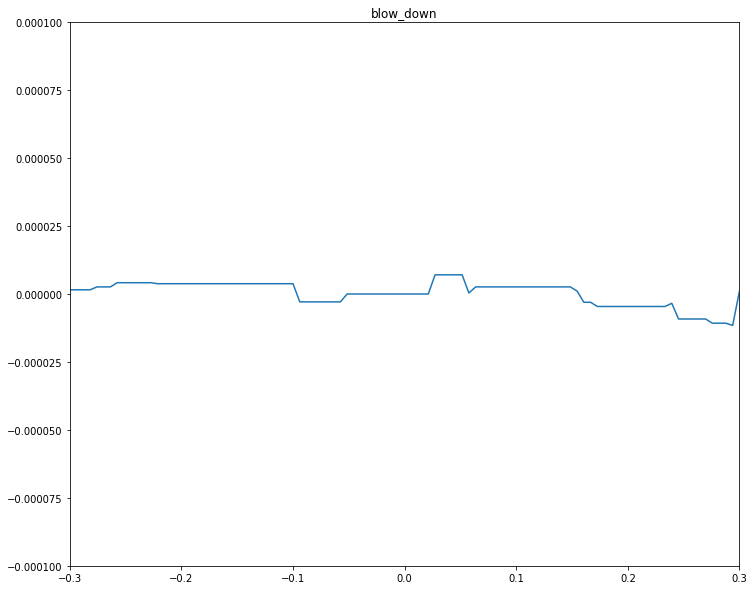

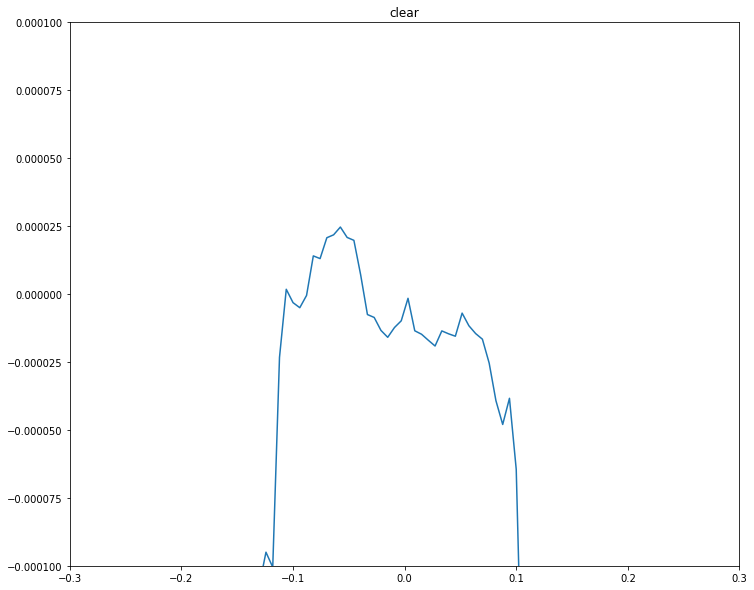

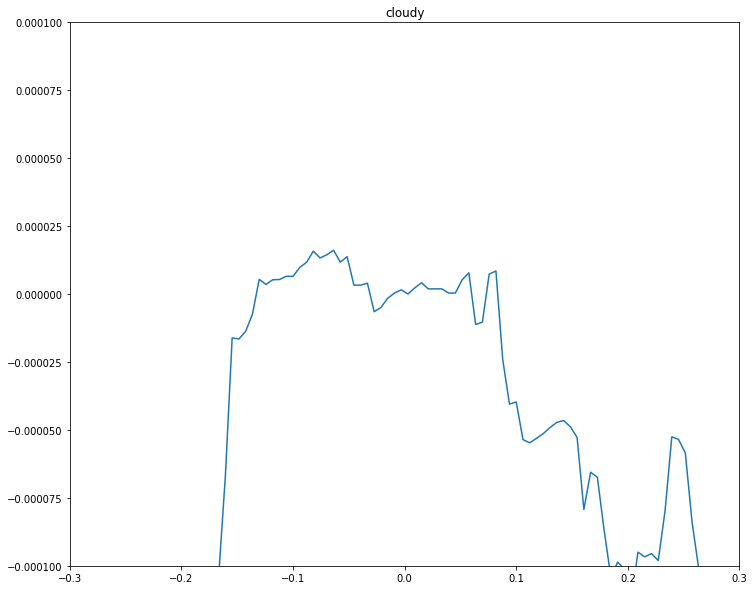

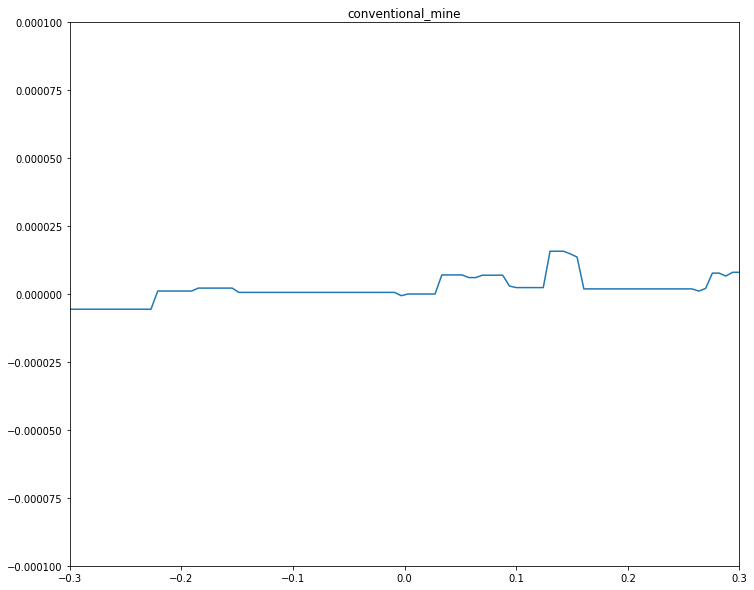

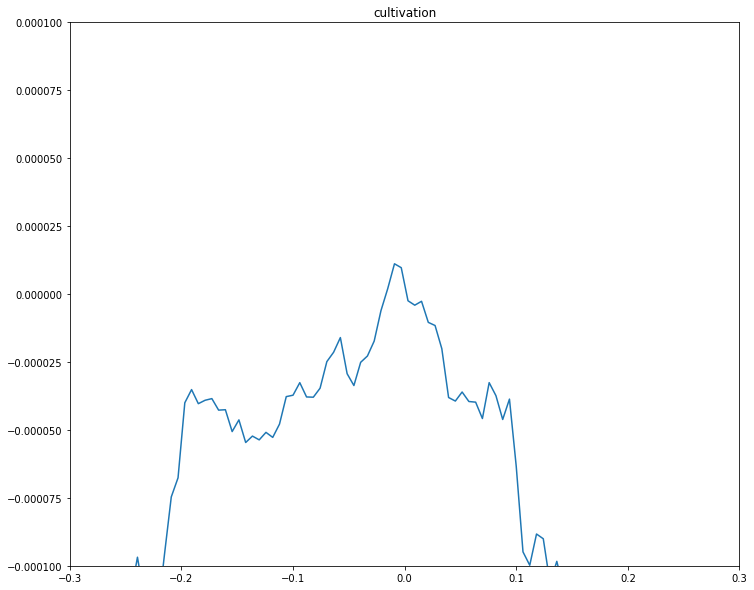

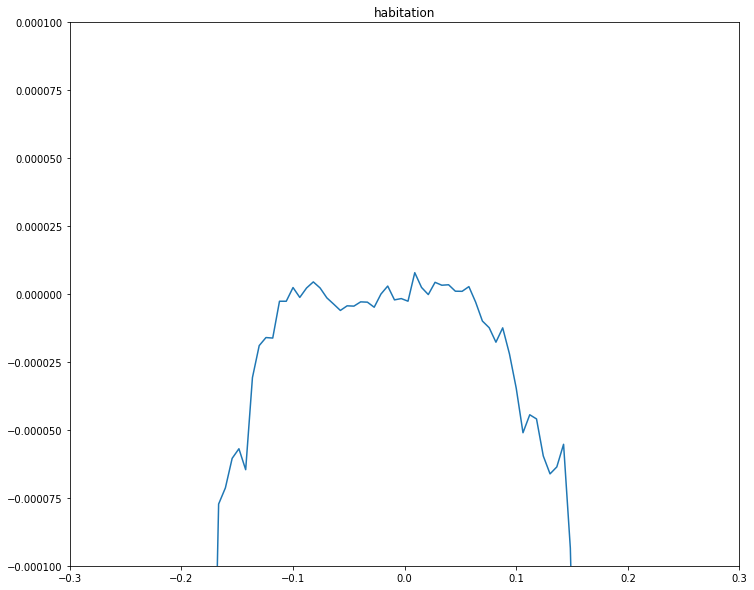

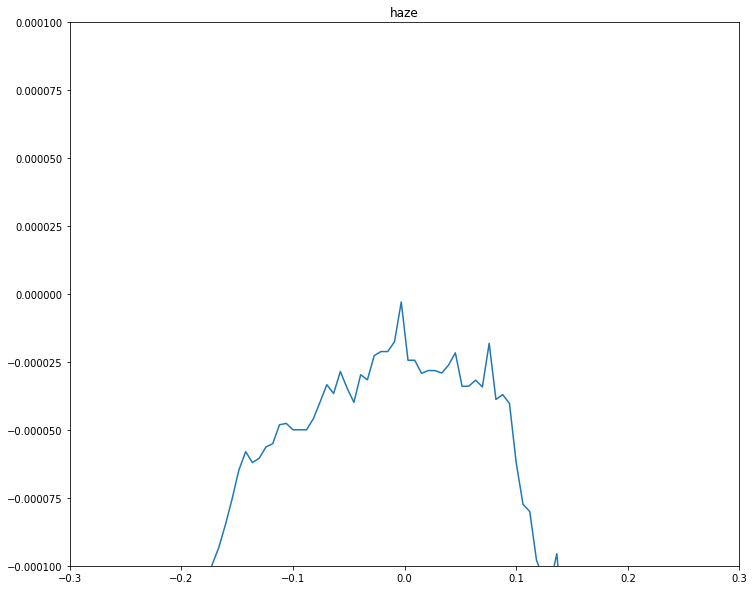

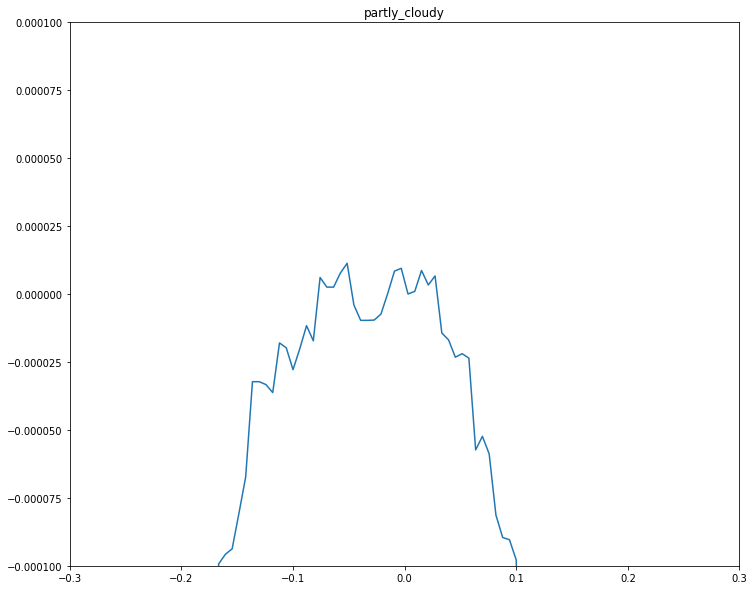

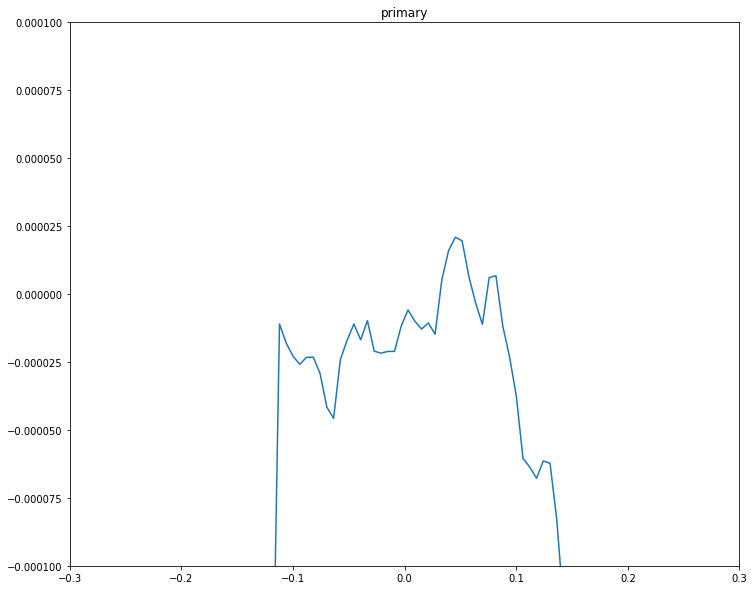

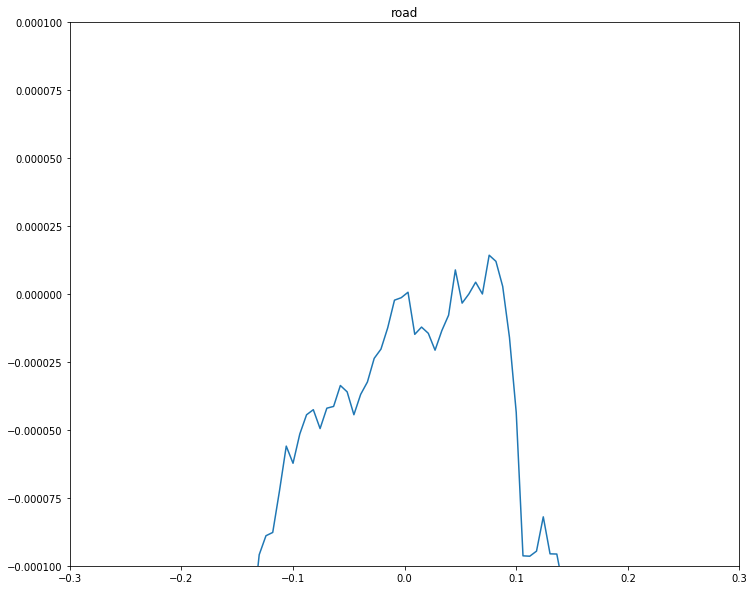

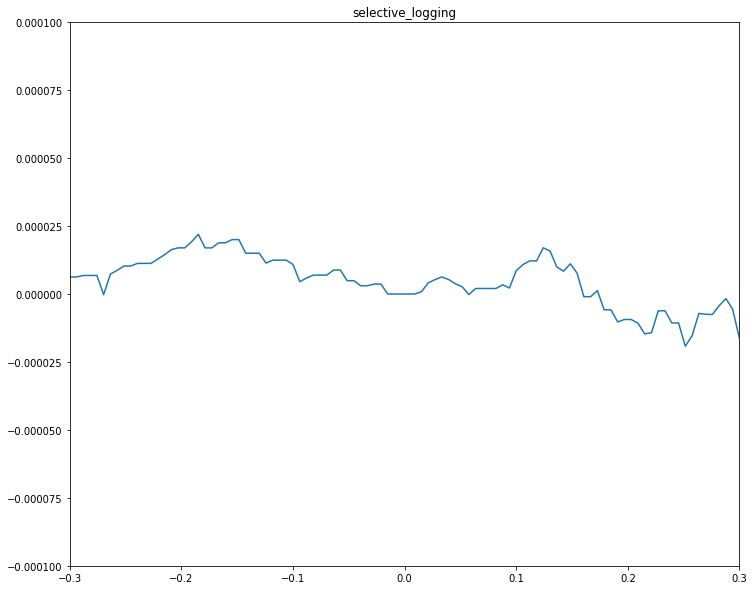

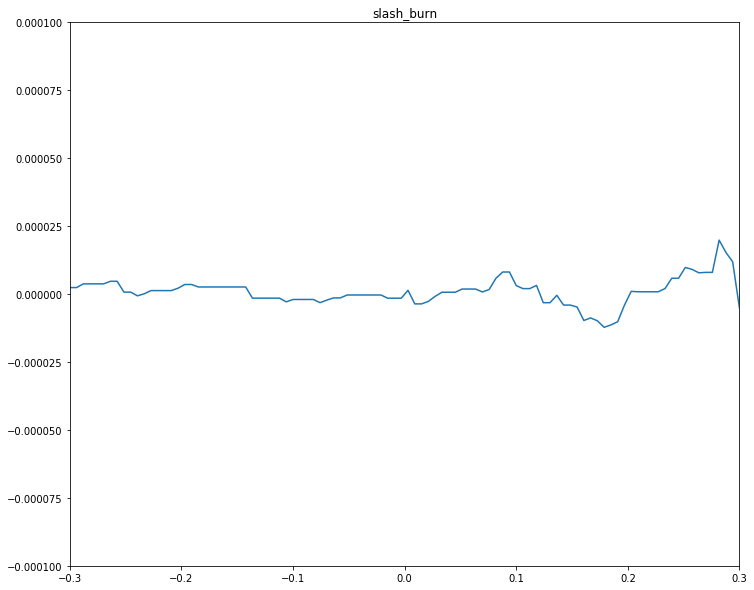

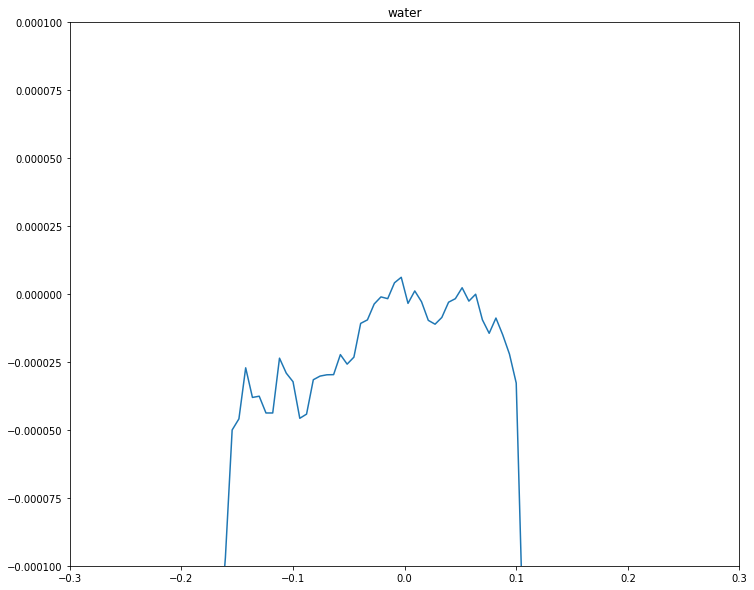

In [104]:
for cls in val_pred.columns:
    plt.figure()
    plt.title(cls)
    scores_count_df[cls].plot(figsize=(12, 10), ylim=(-0.0001, 0.0001));

In [126]:
xs = np.linspace(0, 0.2, 20)
all_deltas = []
for cls in val_pred.columns:
    print('{}'.format(cls))
    cls_deltas = []
    for train_ids, valid_ids in KFold(n_splits=4, shuffle=True).split(val_pred.index):
        train_original_score = f2_score(
            train_flat.iloc[train_ids].as_matrix(),
            (val_pred.iloc[train_ids] > threshold).as_matrix())
        train_score = train_original_score
        best_alpha = 0
        for alpha in xs:
            cpred = val_pred.iloc[train_ids].copy()
            cpred[cls] = (1 - alpha) * val_pred.iloc[train_ids][cls] + alpha * val_neigh_counts.iloc[train_ids][cls]
            score = f2_score(train_flat.iloc[train_ids].as_matrix(), (cpred > threshold).as_matrix())
            if score > train_score:
                train_score = score
                best_alpha = alpha 
        cpred = val_pred.iloc[valid_ids].copy()
        cpred[cls] = ((1 - best_alpha) * val_pred.iloc[valid_ids][cls] +
                      best_alpha * val_neigh_counts.iloc[valid_ids][cls])
        valid_score = f2_score(train_flat.iloc[valid_ids].as_matrix(), (cpred > threshold).as_matrix())
        valid_original_score = f2_score(
            train_flat.iloc[valid_ids].as_matrix(),
            (val_pred.iloc[valid_ids] > threshold).as_matrix())
        print('train: {:+.6f}, valid: {:+.6f}, alpha: {:+.3f}'
              .format(train_score - train_original_score,
                      valid_score - valid_original_score,
                      best_alpha))
        cls_deltas.append(valid_score - valid_original_score)
    print('valid: {:+.6f}'.format(np.mean(cls_deltas)))
    all_deltas.append(np.mean(cls_deltas))
print('all deltas: {:+.6f}'.format(np.mean(all_deltas)))

agriculture
train: +0.000050, valid: +0.000048, alpha: +0.074
train: +0.000081, valid: -0.000128, alpha: +0.116
train: +0.000036, valid: +0.000012, alpha: +0.105
train: +0.000045, valid: +0.000051, alpha: +0.063
valid: -0.000004
artisinal_mine
train: +0.000000, valid: +0.000000, alpha: +0.000
train: +0.000000, valid: +0.000000, alpha: +0.000
train: +0.000000, valid: +0.000000, alpha: +0.000
train: +0.000001, valid: -0.000019, alpha: +0.053
valid: -0.000005
bare_ground
train: +0.000063, valid: +0.000117, alpha: +0.200
train: +0.000076, valid: +0.000076, alpha: +0.200
train: +0.000060, valid: +0.000125, alpha: +0.200
train: +0.000106, valid: -0.000014, alpha: +0.200
valid: +0.000076
blooming
train: +0.000009, valid: -0.000030, alpha: +0.147
train: +0.000004, valid: +0.000000, alpha: +0.011
train: +0.000001, valid: +0.000009, alpha: +0.011
train: +0.000016, valid: -0.000045, alpha: +0.137
valid: -0.000017
blow_down
train: +0.000009, valid: +0.000000, alpha: +0.032
train: +0.000000, valid:

In [127]:
xs = np.linspace(0, 0.1, 10)
all_deltas = []
for cls in val_pred.columns:
    print('{}'.format(cls))
    cls_deltas = []
    for train_ids, valid_ids in KFold(n_splits=4, shuffle=True).split(val_pred.index):
        train_original_score = f2_score(
            train_flat.iloc[train_ids].as_matrix(),
            (val_pred.iloc[train_ids] > threshold).as_matrix())
        train_score = train_original_score
        best_alpha = 0
        for alpha in xs:
            cpred = val_pred.iloc[train_ids].copy()
            cpred[cls] = val_pred.iloc[train_ids][cls] + alpha * val_neigh_counts.iloc[train_ids][cls]
            score = f2_score(train_flat.iloc[train_ids].as_matrix(), (cpred > threshold).as_matrix())
            if score > train_score:
                train_score = score
                best_alpha = alpha 
        cpred = val_pred.iloc[valid_ids].copy()
        cpred[cls] = (val_pred.iloc[valid_ids][cls] +
                      best_alpha * val_neigh_counts.iloc[valid_ids][cls])
        valid_score = f2_score(train_flat.iloc[valid_ids].as_matrix(), (cpred > threshold).as_matrix())
        valid_original_score = f2_score(
            train_flat.iloc[valid_ids].as_matrix(),
            (val_pred.iloc[valid_ids] > threshold).as_matrix())
        print('train: {:+.6f}, valid: {:+.6f}, alpha: {:+.3f}'
              .format(train_score - train_original_score,
                      valid_score - valid_original_score,
                      best_alpha))
        cls_deltas.append(valid_score - valid_original_score)
    print('valid: {:+.6f}'.format(np.mean(cls_deltas)))
    all_deltas.append(np.mean(cls_deltas))
print('all deltas: {:+.6f}'.format(np.mean(all_deltas)))

agriculture
train: +0.000039, valid: +0.000011, alpha: +0.056
train: +0.000022, valid: +0.000061, alpha: +0.056
train: +0.000028, valid: +0.000042, alpha: +0.056
train: +0.000038, valid: +0.000013, alpha: +0.056
valid: +0.000032
artisinal_mine
train: +0.000000, valid: +0.000000, alpha: +0.000
train: +0.000000, valid: +0.000000, alpha: +0.000
train: +0.000000, valid: +0.000000, alpha: +0.000
train: +0.000000, valid: +0.000000, alpha: +0.000
valid: +0.000000
bare_ground
train: +0.000060, valid: -0.000017, alpha: +0.100
train: +0.000019, valid: +0.000106, alpha: +0.100
train: +0.000050, valid: +0.000015, alpha: +0.100
train: +0.000038, valid: +0.000045, alpha: +0.089
valid: +0.000038
blooming
train: +0.000005, valid: -0.000036, alpha: +0.044
train: +0.000000, valid: +0.000000, alpha: +0.000
train: +0.000000, valid: +0.000000, alpha: +0.000
train: +0.000000, valid: +0.000000, alpha: +0.000
valid: -0.000009
blow_down
train: +0.000009, valid: +0.000000, alpha: +0.022
train: +0.000009, valid: